In [1]:
from src.data.eeg_measurement import EegMeasurement
from src.data.eeg_attention_pytorch_dataset import EegAttentionDataset
from src.evaluation.eval_vanilla_ridge import RidgeEvaluator

import numpy as np
import git
import os
import pandas
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import scipy

from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

import git
import src.data.utils as data_utils
import src.evaluation.utils as eval_utils
import pickle

import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

from os.path import join
from pandas import read_csv

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def get_csv_log_file(base_dir, subject):
    """Return absolute path of psychopy csv log-file for given base directory and subject number
    Args:
        base_dir (str): base dir of repository
        subject (int): subject number e.g. 129
    Returns:
        string: path to csv log file of psychopy experiment
    """
    subject_folder = join(base_dir,"data","raw_input", str(subject))
    header_file = ''
    for file in os.listdir(subject_folder):
        if file.endswith('.csv'):
            header_file = file
    assert header_file.endswith('.csv'), "no file with matching datatype found!"
    assert header_file[:3] == str(subject), f"log file should start with subject number {str(subject)} but filename {header_file} was found."
    return join(subject_folder, header_file)

In [3]:
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
subjects = list(range(102,115))
subjects = subjects + list(range(116,117))
subjects = subjects + list(range(118,126))
subjects = subjects + [127, 128, 130]

#defining some global variables
n_subjects = 25
#subjects 115 and 117 are left out --> randomisations have to be adjusted
randomisations = []
for sub in subjects:
    csv_log_path = get_csv_log_file(base_dir, sub)
    psychopy_log_file = read_csv(csv_log_path, sep=',')
    rand = psychopy_log_file.loc[0, 'randomisation']
    randomisations.append(rand)

c_cnn = '#1f77b4'
c_ridge = '#ff7f0e'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/constantin/PhD_Code/cnn-for-aad-in-ci-users/data/raw_input/102'

In [5]:
ridge_attended_raw_path = os.path.join(base_dir, 'reports/metrics/ridge/020/windowed_accuracies/windowed_attended_scores_raw020.pkl')
ridge_distracor_path = os.path.join(base_dir, 'reports/metrics/ridge/020/windowed_accuracies/windowed_distractor_scores_raw020.pkl')
ridge_acc_path = os.path.join(base_dir, 'reports/metrics/ridge/020/windowed_accuracies/windowed_accuracies020.npy')

cnn_attended_raw_path = os.path.join(base_dir, 'reports/metrics/cnn/152pickled_raw/attended_scores_raw.pkl')
cnn_distractor_raw_path = os.path.join(base_dir, 'reports/metrics/cnn/152pickled_raw/distractor_scores_raw.pkl')

cnn_attended_subj_raw_path = os.path.join(base_dir, 'reports/metrics/cnn/153pickled_raw/attended_scores_raw.pkl')
cnn_distractor_subj_raw_path = os.path.join(base_dir, 'reports/metrics/cnn/153pickled_raw/distractor_scores_raw.pkl')

### Loading raw reconstruction scores

Has shape (n_subjects, n_trials, window_lenghts, n_scores)

In [6]:
with open(ridge_attended_raw_path, 'rb') as f:
    ridge_attended_raw = pickle.load(f)
with open(ridge_distracor_path, 'rb') as f:
    ridge_distractor_raw = pickle.load(f)
with open(cnn_attended_raw_path, 'rb') as f:
    cnn_attended_raw = pickle.load(f)
with open(cnn_distractor_raw_path, 'rb') as f:
    cnn_distractor_raw = pickle.load(f)
with open(cnn_attended_subj_raw_path, 'rb') as f:
    cnn_attended_subj_raw = pickle.load(f)
with open(cnn_distractor_subj_raw_path, 'rb') as f:
    cnn_distractor_subj_raw = pickle.load(f)

In [7]:
#ridge_att_raw = data_utils.moveaxis(ridge_attended_raw)
#ridge_distr_raw = data_utils.moveaxis(ridge_distractor_raw)

#correct trals for subjects with randomisation 1
cnn_att_raw = data_utils.correct_trials_list(cnn_attended_raw, randomisations)
cnn_distr_raw = data_utils.correct_trials_list(cnn_distractor_raw, randomisations)

cnn_att_raw_subj = data_utils.correct_trials_list(cnn_attended_subj_raw, randomisations)
cnn_distr_raw_subj = data_utils.correct_trials_list(cnn_distractor_subj_raw, randomisations)

ridge_att_raw = data_utils.correct_trials_list(ridge_attended_raw, randomisations)
ridge_distr_raw = data_utils.correct_trials_list(ridge_distractor_raw, randomisations)

# Generate Dataset

### Separate Polarnacht and Elbewald samples

In [8]:
#elb_distr: elbenwald was in focus: scores of the distractor, meaning pol
#elb_att: elbenwald was in focus: scores of the attended, meaning elb

elb_att_ridge_raw, pol_att_ridge_raw = data_utils.get_elb_pol_attended(ridge_att_raw)
elb_distr_ridge_raw, pol_distr_ridge_raw = data_utils.get_elb_pol_attended(ridge_distr_raw)

elb_att_cnn_raw, pol_att_cnn_raw = data_utils.get_elb_pol_attended(cnn_att_raw)
elb_distr_cnn_raw, pol_distr_cnn_raw = data_utils.get_elb_pol_attended(cnn_distr_raw)

elb_att_cnn_raw_subj, pol_att_cnn_raw_subj = data_utils.get_elb_pol_attended(cnn_att_raw_subj)
elb_distr_cnn_raw_subj, pol_distr_cnn_raw_subj = data_utils.get_elb_pol_attended(cnn_distr_raw_subj)

### Extracting Scores of Elbenwald and Polarnacht independent of the focus

**For raw data we need to specify a window length, because the lists are not of equal length**

### Plotting the scores of Elbenwald and Polarnacht independent of the focus

**Sanity check to make sense of the data**

In [9]:
lin_acc_thres_list = []
lin_acc_svm_list = []
lin_elb_recall_thres_list, lin_elb_prec_thres_list, lin_elb_f1_thres_list, lin_pol_recall_thres_list, lin_pol_prec_thres_list, lin_pol_f1_thres_list = [], [], [], [], [], []

cnn_acc_thres_list = []
cnn_acc_svm_list = []
cnn_elb_recall_thres_list, cnn_elb_prec_thres_list, cnn_elb_f1_thres_list, cnn_pol_recall_thres_list, cnn_pol_prec_thres_list, cnn_pol_f1_thres_list = [], [], [], [], [], []

cnn_acc_thres_list_subj = []
cnn_acc_svm_list_subj = []
cnn_elb_recall_thres_list_subj, cnn_elb_prec_thres_list_subj, cnn_elb_f1_thres_list_subj, cnn_pol_recall_thres_list_subj, cnn_pol_prec_thres_list_subj, cnn_pol_f1_thres_list_subj = [], [], [], [], [], []

for window_index in range(0, 1):
    #create dataset for current window length
    X_lin_raw, y_lin_raw, cv_lin = eval_utils.create_dataset(elb_att_ridge_raw, elb_distr_ridge_raw, pol_att_ridge_raw, pol_distr_ridge_raw, window_index, n_subjects=n_subjects)
    X_cnn_raw, y_cnn_raw, cv_cnn = eval_utils.create_dataset(elb_att_cnn_raw, elb_distr_cnn_raw, pol_att_cnn_raw, pol_distr_cnn_raw, window_index, n_subjects=n_subjects)
    X_cnn_raw_subj, y_cnn_raw_subj, cv_cnn_subj = eval_utils.create_dataset(elb_att_cnn_raw_subj, elb_distr_cnn_raw_subj, pol_att_cnn_raw_subj, pol_distr_cnn_raw_subj, window_index, n_subjects=n_subjects)

    #eval thresholding
    lin_acc_thres, lin_elb_recall_thres, lin_elb_prec_thres, lin_elb_f1_thres, lin_pol_recall_thres, lin_pol_prec_thres, lin_pol_f1_thres = eval_utils.score_thresholding(X_lin_raw, y_lin_raw, cv_lin)
    cnn_acc_thres, cnn_elb_recall_thres, cnn_elb_prec_thres, cnn_elb_f1_thres, cnn_pol_recall_thres, cnn_pol_prec_thres, cnn_pol_f1_thres = eval_utils.score_thresholding(X_cnn_raw, y_cnn_raw, cv_cnn)
    cnn_acc_subj_thres, cnn_elb_recall_subj_thres, cnn_elb_prec_subj_thres, cnn_elb_f1_subj_thres, cnn_pol_recall_subj_thres, cnn_pol_prec_subj_thres, cnn_pol_f1_subj_thres = eval_utils.score_thresholding(X_cnn_raw_subj, y_cnn_raw_subj, cv_cnn_subj)

    #eval SVM
    lin_acc_svm, lin_elb_recall_svm, lin_elb_prec_svm, lin_elb_f1_svm, lin_pol_recall_svm, lin_pol_prec_svm, lin_pol_f1_svm = eval_utils.score_SVM(X_lin_raw,y_lin_raw, cv = cv_lin)
    cnn_acc_svm, cnn_elb_recall_svm, cnn_elb_prec_svm, cnn_elb_f1_svm, cnn_pol_recall_svm, cnn_pol_prec_svm, cnn_pol_f1_svm = eval_utils.score_SVM(X_cnn_raw,y_cnn_raw, cv = cv_cnn)
    cnn_acc_svm_subj, cnn_elb_recall_svm_subj, cnn_elb_prec_svm_subj, cnn_elb_f1_svm_subj, cnn_pol_recall_svm_subj, cnn_pol_prec_svm_subj, cnn_pol_f1_svm_subj = eval_utils.score_SVM(X_cnn_raw_subj,y_cnn_raw_subj, cv = cv_cnn_subj)

    #keep track of scores
    lin_acc_thres_list.append(lin_acc_thres)
    lin_acc_svm_list.append(lin_acc_svm)
    lin_elb_recall_thres_list.append(lin_elb_recall_thres)
    lin_elb_prec_thres_list.append(lin_elb_prec_thres)
    lin_elb_f1_thres_list.append(lin_elb_f1_thres)
    lin_pol_recall_thres_list.append(lin_pol_recall_thres)
    lin_pol_prec_thres_list.append(lin_pol_prec_thres)
    lin_pol_f1_thres_list.append(lin_pol_f1_thres)

    cnn_acc_thres_list.append(cnn_acc_thres)
    cnn_acc_svm_list.append(cnn_acc_svm)
    cnn_elb_recall_thres_list.append(cnn_elb_recall_thres)
    cnn_elb_prec_thres_list.append(cnn_elb_prec_thres)
    cnn_elb_f1_thres_list.append(cnn_elb_f1_thres)
    cnn_pol_recall_thres_list.append(cnn_pol_recall_thres)
    cnn_pol_prec_thres_list.append(cnn_pol_prec_thres)
    cnn_pol_f1_thres_list.append(cnn_pol_f1_thres)

    cnn_acc_thres_list_subj.append(cnn_acc_subj_thres)
    cnn_acc_svm_list_subj.append(cnn_acc_svm_subj)
    cnn_elb_recall_thres_list_subj.append(cnn_elb_recall_subj_thres)
    cnn_elb_prec_thres_list_subj.append(cnn_elb_prec_subj_thres)
    cnn_elb_f1_thres_list_subj.append(cnn_elb_f1_subj_thres)
    cnn_pol_recall_thres_list_subj.append(cnn_pol_recall_subj_thres)
    cnn_pol_prec_thres_list_subj.append(cnn_pol_prec_subj_thres)
    cnn_pol_f1_thres_list_subj.append(cnn_pol_f1_subj_thres)

/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/src-0.1.0-py3.11.egg/src/evaluation/utils.py:107: RuntimeWarning: invalid value encountered in scalar divide
  elb_precision_thr = true_pos / (true_pos + false_pos)


In [10]:
#cast to numpy arrays and calculate mean
lin_acc_thres_mean, lin_acc_svm_mean = np.mean(lin_acc_thres_list), np.mean(lin_acc_svm_list)
lin_elb_recall_thres_mean, lin_elb_prec_thres_mean, lin_elb_f1_thres_mean = np.mean(lin_elb_recall_thres_list), np.mean(lin_elb_prec_thres_list), np.mean(lin_elb_f1_thres_list)
lin_pol_recall_thres_mean, lin_pol_prec_thres_mean, lin_pol_f1_thres_mean = np.mean(lin_pol_recall_thres_list), np.mean(lin_pol_prec_thres_list), np.mean(lin_pol_f1_thres_list)
lin_elb_recall_svm_mean, lin_elb_prec_svm_mean, lin_elb_f1_svm_mean = np.mean(lin_elb_recall_svm), np.mean(lin_elb_prec_svm), np.mean(lin_elb_f1_svm)
lin_pol_recall_svm_mean, lin_pol_prec_svm_mean, lin_pol_f1_svm_mean = np.mean(lin_pol_recall_svm), np.mean(lin_pol_prec_svm), np.mean(lin_pol_f1_svm)

cnn_acc_thres_mean, cnn_acc_svm_mean = np.mean(cnn_acc_thres_list), np.mean(cnn_acc_svm_list)
cnn_elb_recall_thres_mean, cnn_elb_prec_thres_mean, cnn_elb_f1_thres_mean = np.mean(cnn_elb_recall_thres_list), np.nanmean(cnn_elb_prec_thres_list), np.nanmean(cnn_elb_f1_thres_list)
cnn_pol_recall_thres_mean, cnn_pol_prec_thres_mean, cnn_pol_f1_thres_mean = np.mean(cnn_pol_recall_thres_list), np.mean(cnn_pol_prec_thres_list), np.mean(cnn_pol_f1_thres_list)
cnn_elb_recall_svm_mean, cnn_elb_prec_svm_mean, cnn_elb_f1_svm_mean = np.mean(cnn_elb_recall_svm), np.mean(cnn_elb_prec_svm), np.mean(cnn_elb_f1_svm)
cnn_pol_recall_svm_mean, cnn_pol_prec_svm_mean, cnn_pol_f1_svm_mean = np.mean(cnn_pol_recall_svm), np.mean(cnn_pol_prec_svm), np.mean(cnn_pol_f1_svm)

cnn_acc_thres_mean_subj, cnn_acc_svm_mean_subj = np.mean(cnn_acc_thres_list_subj), np.mean(cnn_acc_svm_list_subj)
cnn_elb_recall_thres_mean_subj, cnn_elb_prec_thres_mean_subj, cnn_elb_f1_thres_mean_subj = np.mean(cnn_elb_recall_thres_list_subj), np.mean(cnn_elb_prec_thres_list_subj), np.mean(cnn_elb_f1_thres_list_subj)
cnn_pol_recall_thres_mean_subj, cnn_pol_prec_thres_mean_subj, cnn_pol_f1_thres_mean_subj = np.mean(cnn_pol_recall_thres_list_subj), np.mean(cnn_pol_prec_thres_list_subj), np.mean(cnn_pol_f1_thres_list_subj)
cnn_elb_recall_svm_mean_subj, cnn_elb_prec_svm_mean_subj, cnn_elb_f1_svm_mean_subj = np.mean(cnn_elb_recall_svm_subj), np.mean(cnn_elb_prec_svm_subj), np.mean(cnn_elb_f1_svm_subj)
cnn_pol_recall_svm_mean_subj, cnn_pol_prec_svm_mean_subj, cnn_pol_f1_svm_mean_subj = np.mean(cnn_pol_recall_svm_subj), np.mean(cnn_pol_prec_svm_subj), np.mean(cnn_pol_f1_svm_subj)

In [11]:
ridge_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/012/windowed_svm_values'
cnn_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/122/windowed_svm_valued'
cnn_path_subj = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/123/windowed_svm_valued'

lin_acc_thres_list = np.array(lin_acc_thres_list)
lin_acc_svm_list = np.array(lin_acc_svm_list)

cnn_acc_thres_list = np.array(cnn_acc_thres_list)
cnn_acc_svm_list = np.array(cnn_acc_svm_list)

cnn_acc_thres_list_subj = np.array(cnn_acc_thres_list_subj)
cnn_acc_svm_list_subj = np.array(cnn_acc_svm_list_subj)

# np.save(os.path.join(ridge_path, 'lin_acc_thres_list.npy'), lin_acc_thres_list)
# np.save(os.path.join(ridge_path, 'lin_acc_svm_list.npy'), lin_acc_svm_list)

# np.save(os.path.join(cnn_path, 'cnn_acc_thres_list.npy'), cnn_acc_thres_list)
# np.save(os.path.join(cnn_path, 'cnn_acc_svm_list.npy'), cnn_acc_svm_list)

# np.save(os.path.join(cnn_path_subj, 'cnn_acc_thres_list.npy'), cnn_acc_thres_list_subj)
# np.save(os.path.join(cnn_path_subj, 'cnn_acc_svm_list.npy'), cnn_acc_svm_list_subj)

### Gather data for feature plane plot

In [13]:
model = SVC(kernel='linear', C=100, random_state=0)

subj = 22
X_lin_raw, y_lin_raw, cv_lin = eval_utils.create_dataset(elb_att_ridge_raw, elb_distr_ridge_raw, pol_att_ridge_raw, pol_distr_ridge_raw, window_index, n_subjects=n_subjects)
X_cnn_raw, y_cnn_raw, cv_cnn = eval_utils.create_dataset(elb_att_cnn_raw, elb_distr_cnn_raw, pol_att_cnn_raw, pol_distr_cnn_raw, window_index, n_subjects=n_subjects)
X_cnn_raw_subj, y_cnn_raw_subj, cv_cnn_subj = eval_utils.create_dataset(elb_att_cnn_raw_subj, elb_distr_cnn_raw_subj, pol_att_cnn_raw_subj, pol_distr_cnn_raw_subj, window_index, n_subjects=n_subjects)

X_train_lin, y_train_lin = X_lin_raw[cv_lin[subj][0]], y_lin_raw[cv_lin[subj][0]]
X_test_lin, y_test_lin = X_lin_raw[cv_lin[subj][1]], y_lin_raw[cv_lin[subj][1]]

X_train_cnn, y_train_cnn = X_cnn_raw[cv_cnn[subj][0]], y_cnn_raw[cv_cnn[subj][0]]
X_test_cnn, y_test_cnn = X_cnn_raw[cv_cnn[subj][1]], y_cnn_raw[cv_cnn[subj][1]]

X_train_cnn_subj, y_train_cnn_subj = X_cnn_raw_subj[cv_cnn_subj[subj][0]], y_cnn_raw_subj[cv_cnn_subj[subj][0]]
X_test_cnn_subj, y_test_cnn_subj = X_cnn_raw_subj[cv_cnn_subj[subj][1]], y_cnn_raw_subj[cv_cnn_subj[subj][1]]

clf_lin = model.fit(X_train_lin, y_train_lin)
clf_cnn = model.fit(X_train_cnn, y_train_cnn)
clf_cnn_subj = model.fit(X_train_cnn_subj, y_train_cnn_subj)

elb_attended_lin = X_train_lin[y_train_lin == 1, :]
pol_attended_lin = X_train_lin[y_train_lin == 0, :]
elb_attended_test_lin = X_test_lin[y_test_lin == 1, :]
pol_attended_test_lin = X_test_lin[y_test_lin == 0, :]

elb_attended_cnn, pol_attended_cnn = X_train_cnn[y_train_cnn == 1, :], X_train_cnn[y_train_cnn == 0, :]
elb_attended_test_cnn, pol_attended_test_cnn = X_test_cnn[y_test_cnn == 1, :], X_test_cnn[y_test_cnn == 0, :]

elb_attended_cnn_subj, pol_attended_cnn_subj = X_train_cnn_subj[y_train_cnn_subj == 1, :], X_train_cnn_subj[y_train_cnn_subj == 0, :]
elb_attended_test_cnn_subj, pol_attended_test_cnn_subj = X_test_cnn_subj[y_test_cnn_subj == 1, :], X_test_cnn_subj[y_test_cnn_subj == 0, :]


### Figure parameters

In [14]:
label_fontsize = 10
tick_fontsize = 9

#color_polarnacht ='#1f77b4'
color_elbenwald = 'slategrey'
color_polarnacht = 'darkseagreen'

# color_polarnacht = 'steelblue'
# color_elbenwald = 
#'#ff7f0e'
color_svm = 'goldenrod'
color_thres = 'steelblue'

marker_polarnacht = '^'
marker_elbenwald = 'o'

alpha_train, alpha_test = 0.4, 1
s_train = 2
s_test = 18

linestyle_diagonal = '-.'
linestyle_svm = '-'
linewidth = 1.5

axis_linewidth = 1.0

y_ticks = [0, 0.2, 0.4]

x_text_0 = -0.20
x_text_1 = 0.32

In [22]:
def plot_features_space(ax0,ax1,ax2,ax3):
    elb_train = ax0.scatter(elb_attended_lin[:,0], elb_attended_lin[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended train', alpha=alpha_train, s = s_train)
    pol_train = ax0.scatter(pol_attended_lin[:,0], pol_attended_lin[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended train', alpha=alpha_train, s = s_train)
    elb_test = ax0.scatter(elb_attended_test_lin[:,0], elb_attended_test_lin[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended test', alpha=alpha_test, s=s_test)
    pol_test = ax0.scatter(pol_attended_test_lin[:,0], pol_attended_test_lin[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended test', alpha=alpha_test, s=s_test)

    diago = ax0.plot([0, 1], [0, 1], linestyle = linestyle_diagonal, transform=ax0.transAxes, label = 'diagonal', c = color_thres, linewidth=linewidth)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf_lin,
        X_lin_raw,
        plot_method="contour",
        colors=color_svm,
        levels=[0],
        alpha=1.0,
        linestyles=[linestyle_svm],
        linewidths=[linewidth],
        label = 'svm',
        ax=ax0
    )

    ax0.set_xlim([-0.1,0.5])
    ax0.set_ylim([-0.1,0.5])

    ax0.set_xlabel(r'$r_{s1}$', fontsize = label_fontsize)
    ax0.set_ylabel(r'$r_{s2}$', fontsize = label_fontsize)
    ax0.set_title('Linear Decoding\n', fontsize=label_fontsize)
    ax0.text(x_text_0,0.58, '(a)')
    #ax0.legend(loc='lower right')
    ax0.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax0.set_yticks(y_ticks)


    ax1.scatter(elb_attended_cnn[:,0], elb_attended_cnn[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended train', alpha=alpha_train, s=s_train)
    ax1.scatter(pol_attended_cnn[:,0], pol_attended_cnn[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended train', alpha=alpha_train, s=s_train)
    ax1.scatter(elb_attended_test_cnn[:,0], elb_attended_test_cnn[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended test', alpha=alpha_test, s=s_test)
    ax1.scatter(pol_attended_test_cnn[:,0], pol_attended_test_cnn[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended test', alpha=alpha_test, s=s_test)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf_cnn,
        X_cnn_raw,
        plot_method="contour",
        colors=color_svm,
        levels=[0],
        alpha=1.0,
        linestyles=[linestyle_svm],
        linewidths=[linewidth],
        label = 'svm',
        ax=ax1,
    )

    ax1.plot([0, 1], [0, 1], linestyle = linestyle_diagonal, transform=ax1.transAxes, label = 'diagonal', c = color_thres, linewidth = linewidth)

    ax1.set_xlim([-0.1,0.5])
    ax1.set_ylim([-0.1,0.5])

    ax1.set_xlabel(r'$r_{s1}$', fontsize = label_fontsize)
    #ax1.set_ylabel(r'$r_{pol}$', fontsize = label_fontsize)
    ax1.set_title('CNN Decoding\n(pre-trained)', fontsize=label_fontsize)
    ax1.text(x_text_0,0.58, '(c)')
    #ax1.legend(loc='upper left')
    ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax1.set_yticks(y_ticks)


    ax2.scatter(elb_attended_cnn_subj[:,0], elb_attended_cnn_subj[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended train', alpha=alpha_train, s=s_train)
    ax2.scatter(pol_attended_cnn_subj[:,0], pol_attended_cnn_subj[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended train', alpha=alpha_train, s=s_train)
    ax2.scatter(elb_attended_test_cnn_subj[:,0], elb_attended_test_cnn_subj[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended test', alpha=alpha_test, s=s_test)
    ax2.scatter(pol_attended_test_cnn_subj[:,0], pol_attended_test_cnn_subj[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended test', alpha=alpha_test, s=s_test)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf_cnn_subj,
        X_cnn_raw,
        plot_method="contour",
        colors=color_svm,
        levels=[0],
        alpha=1.0,
        linestyles=[linestyle_svm],
        linewidths=[linewidth],
        label = 'svm',
        ax=ax2,
    )

    ax2.plot([0, 1], [0, 1], linestyle = linestyle_diagonal, transform=ax2.transAxes, label = 'diagonal', c = color_thres, linewidth = linewidth)

    ax2.set_xlim([-0.1,0.5])
    ax2.set_ylim([-0.1,0.5])

    ax2.set_xlabel(r'$r_{s1}$', fontsize = label_fontsize)
    #ax1.set_ylabel(r'$r_{pol}$', fontsize = label_fontsize)
    ax2.set_title('CNN Decoding\n(not pre-trained)', fontsize=label_fontsize)
    ax2.text(x_text_0,0.58, '(b)')
    #ax1.legend(loc='upper left')
    ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax2.set_yticks(y_ticks)

    ax3.legend([Line2D([0], [0], color=color_svm, linewidth=linewidth, linestyle= linestyle_svm), Line2D([0], [0], color=color_thres, linewidth=linewidth, linestyle= linestyle_diagonal), 
                elb_train, pol_train, elb_test, pol_test], 
                ['SVM', 'Naive\nClassifier', 's1 attended\n(Training)', 's2 attended\n(Training)', 's1 attended\n(Test)', 's2 attended\n(Test)'], loc='center left', 
                fontsize=tick_fontsize, frameon=True)

    ax3.axis('off')

    for axis in [ax0, ax1, ax2]:
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.spines['left'].set_linewidth(axis_linewidth)
        axis.spines['bottom'].set_linewidth(axis_linewidth)

In [20]:
def plot_metrics(ax0,ax1,ax2,ax3):
    metrics = ('accuracy', 'recall (s1)', 'recall (s2)', 'precision (s1)', 'precision (s2)')
    model_performances_lin = {
        'Thresholding' : (lin_acc_thres_mean, lin_elb_recall_thres_mean, lin_pol_recall_thres_mean, lin_elb_prec_thres_mean, lin_pol_prec_thres_mean),
        'SVM' : (lin_acc_svm_mean, lin_elb_recall_svm_mean, lin_pol_recall_svm_mean, lin_elb_prec_svm_mean, lin_pol_prec_svm_mean),
    }

    model_performances_cnn = {
        'Thresholding' : (cnn_acc_thres_mean, cnn_elb_recall_thres_mean, cnn_pol_recall_thres_mean, cnn_elb_prec_thres_mean, cnn_pol_prec_thres_mean),
        'SVM' : (cnn_acc_svm_mean, cnn_elb_recall_svm_mean, cnn_pol_recall_svm_mean, cnn_elb_prec_svm_mean, cnn_pol_prec_svm_mean),
    }

    model_performances_cnn_subj = {
        'Thresholding' : (cnn_acc_thres_mean_subj, cnn_elb_recall_thres_mean_subj, cnn_pol_recall_thres_mean_subj, cnn_elb_prec_thres_mean_subj, cnn_pol_prec_thres_mean_subj),
        'SVM' : (cnn_acc_svm_mean_subj, cnn_elb_recall_svm_mean_subj, cnn_pol_recall_svm_mean_subj, cnn_elb_prec_svm_mean_subj, cnn_pol_prec_svm_mean_subj),
    }
    x = np.arange(len(metrics))[::-1]  # the label locations
    width = 0.3  # the width of the bars
    multiplier = 0

    for axis, model_performances in zip([ax0, ax1, ax2], [model_performances_lin, model_performances_cnn, model_performances_cnn_subj]):
        for model, performance in model_performances.items():
            if model == 'Thresholding':
                rects_thres = axis.barh(x - width/2 + multiplier*width, performance, width, label=model, color = color_thres)
                #axis.bar_label(rects_thres, padding=0, fmt='%.2f')
            else:
                rects_svm = axis.barh(x - width/2 + multiplier*width, performance, width, label=model, color = color_svm)
                #axis.bar_label(rects_svm, padding=0, fmt='%.2f')
            
            multiplier += 1
        axis.set_xlim([0.42,1.0])
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.spines['left'].set_linewidth(axis_linewidth)
        axis.spines['bottom'].set_linewidth(axis_linewidth)
        axis.set_xticks([0.5,0.7,0.9], labels = [0.5,0.7,0.9], fontsize=tick_fontsize)

        axis.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, symbol='%'))
        #axis.set_xlabel(('(%)'), fontsize = tick_fontsize)

    ax0.set_yticks(x, labels = metrics, fontsize = tick_fontsize)
    ax1.set_yticks([])
    ax2.set_yticks([])

    ax3.axis('off')
    ax3.legend([rects_svm[-1], rects_thres[-1]], ['SVM','Naive\nClassifier'], loc='center left', fontsize=tick_fontsize, frameon=True)

/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'label'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'label'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'label'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


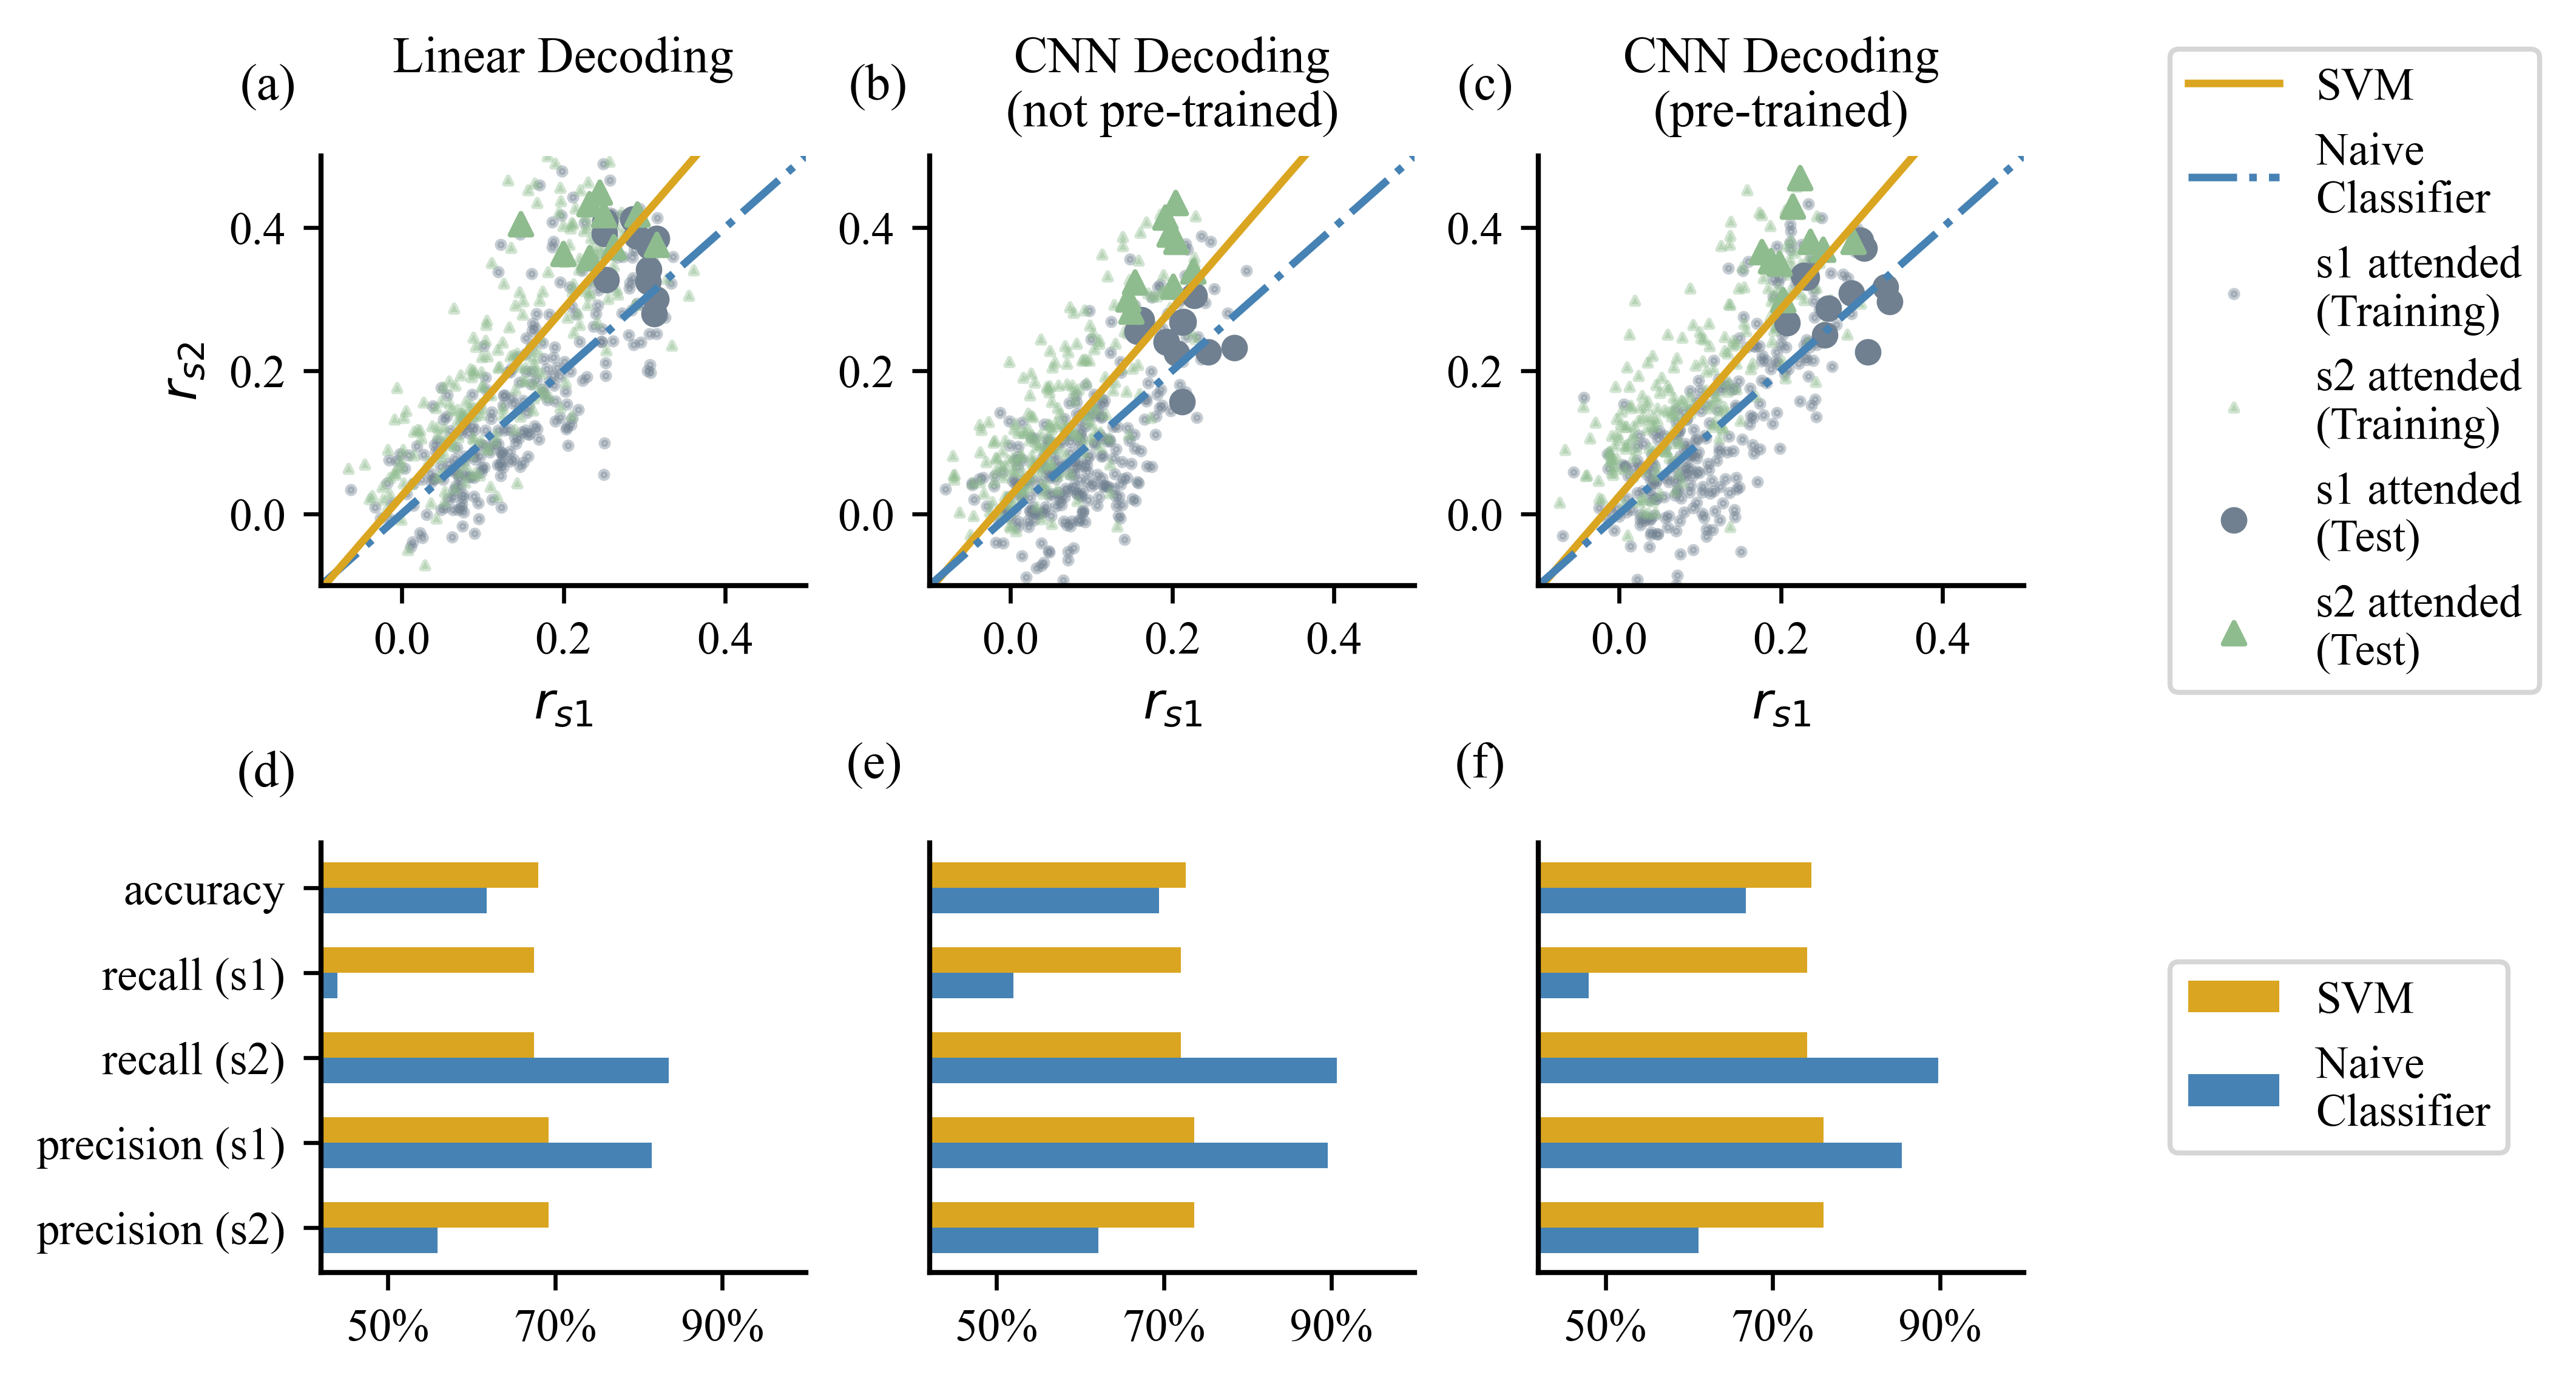

In [23]:
fig = plt.figure(figsize=(7.16,4.2), dpi=600)
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=[1, 1, 1, 0.4], wspace = 0.3, hspace = 0.6)
[[ax0, ax1, ax2, ax3], [ax4, ax5, ax6, ax7]]  = spec.subplots()
plot_features_space(ax0, ax2, ax1, ax3)

plt.subplots_adjust(bottom=0.15)
plot_metrics(ax4, ax6, ax5, ax7)
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
#plt.tight_layout()

letters = ['(d)', '(e)', '(f)']
# for ax, letter, i in zip([ax4, ax5, ax6], letters, range(0,3)):
#     #ax.set_title(letter, fontsize=label_fontsize)
ax4.text(x_text_1,5.2, letters[0])
ax5.text(x_text_1,6.5, letters[1])
ax6.text(x_text_1,5.9, letters[2])

#ax0.text(1,1, letters[0], fontsize=label_fontsize, ha='center')


fig_path = os.path.join(base_dir, 'reports', 'figures', 'learnable_thresholding')
os.makedirs(fig_path, exist_ok=True)
fig.savefig(os.path.join(fig_path, 'svm_example.png'), bbox_inches='tight', format='png', dpi=600)
fig.savefig(os.path.join(fig_path, 'svm_example.pdf'), bbox_inches='tight', format='pdf', dpi=600)
fig.savefig(os.path.join(fig_path, 'svm_example.svg'), bbox_inches='tight', format='svg', dpi=600)